# Instore Price Synthetic Control Method

In [1]:
from causalimpact import CausalImpact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import dataframe_pivot
from src import dataframe_synthetic_control_preparation
from src import query_engines
from src import dataframe_visualizer

q = query_engines.QueryEngines()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# PT Auchan

In [2]:
QUERY_NAME = "time_series.sql"  # With sql
START_DATE = "'2025-01-07'"
END_DATE = "'2025-03-07'"
COUNTRY = "'PT'"
NAME_CONDITION = "(s.store_name = 'Auchan' or s.store_name = 'MyAuchan')"
SYNTHETIC_GROUP = 10

params = [
    {"name": "start_date", "value": str(START_DATE)},
    {"name": "end_date", "value": str(END_DATE)},
    {"name": "country", "value": str(COUNTRY)},
    {"name": "name_condition", "value": str(NAME_CONDITION)},
    {"name": "synthetic_group", "value": str(SYNTHETIC_GROUP)},
]

q.prepare_query(QUERY_NAME, params=params, output_file='PT_Auchan', load_previous=True)

df = q.query_run_starburst()
df.head()


,p_creation_date,store_name,is_target,rank,impressions,accessed,orders,ctr,cvr
0,2025-01-19,Pingo Doce,0,3,11315,3206,943,0.28,0.08
1,2025-02-21,Pingo Doce,0,3,9692,2683,758,0.28,0.08
2,2025-01-25,Minipreço,0,2,14725,2998,828,0.20,0.06
3,2025-03-04,Continente,0,1,19719,10248,3672,0.52,0.19
4,2025-01-09,Pingo Doce,0,3,7782,2089,650,0.27,0.08


## Auchan

In [3]:
# Pivot dataframe
NOT_Y = ['MyAuchan', 'O Melhor Croissant da Minha Rua']
T = 'p_creation_date'
Y = 'ctr_sum_Auchan'

df_filtered = df[~df['store_name'].isin(NOT_Y)].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
p_creation_date,,,,,,,,,,
2025-01-07,0.17,0.03,0.06,0.47,0.08,0.14,0.22,0.06,0.27,0.07
2025-01-08,0.19,0.03,0.05,0.48,0.08,0.16,0.23,0.05,0.28,0.07
2025-01-09,0.16,0.04,0.05,0.45,0.09,0.17,0.21,0.06,0.27,0.06
2025-01-10,0.16,0.03,0.05,0.45,0.07,0.15,0.20,0.07,0.26,0.07
2025-01-11,0.16,0.03,0.05,0.47,0.09,0.19,0.21,0.08,0.27,0.07


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01680D+00    |proj g|=  3.43596D-01

At iterate    5    f=  9.23987D-01    |proj g|=  3.93324D-02

At iterate   10    f=  9.15155D-01    |proj g|=  2.96641D-02

At iterate   15    f=  9.14586D-01    |proj g|=  4.21694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     19     27      1     0     0   4.939D-05   9.146D-01
  F =  0.91458344067759356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


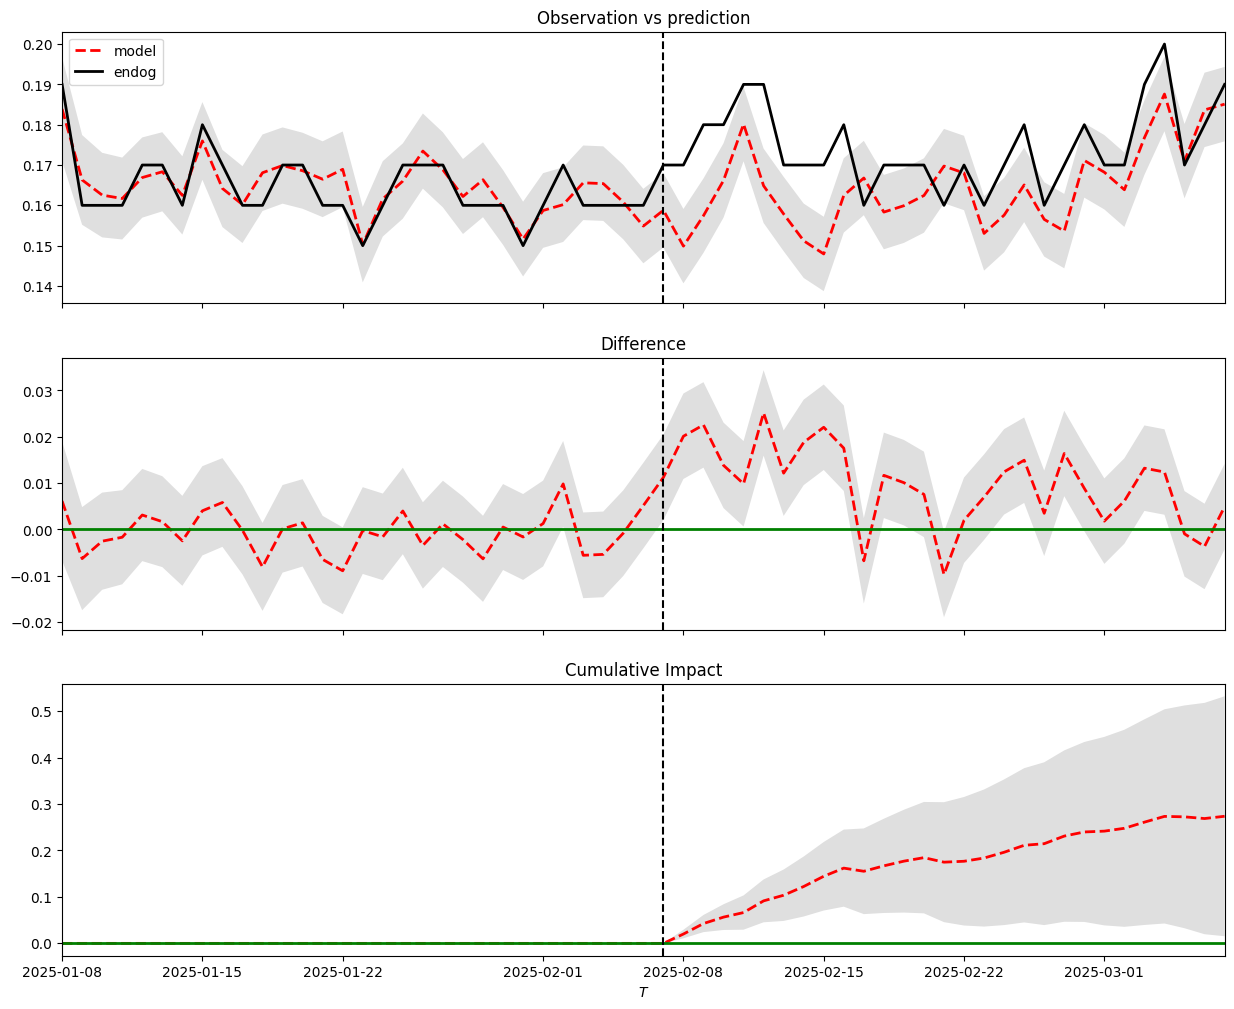

In [9]:
START_DATE = "2025-01-07"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2025-02-07"
POST_TREATMENT_DATE = "2025-02-08"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()

## MyAuchan

In [11]:
# Pivot dataframe
NOT_Y = 'Auchan'
T = 'p_creation_date'
Y = 'ctr_sum_MyAuchan'

df_filtered = df[df['store_name'] != NOT_Y].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
p_creation_date,,,,,,,,,,,
2025-01-07,0.16,0.03,0.06,0.47,0.08,0.14,0.22,0.06,0.05,0.27,0.07
2025-01-08,0.16,0.03,0.05,0.48,0.08,0.16,0.23,0.05,0.06,0.28,0.07
2025-01-09,0.15,0.04,0.05,0.45,0.09,0.17,0.21,0.06,0.05,0.27,0.06
2025-01-10,0.16,0.03,0.05,0.45,0.07,0.15,0.20,0.07,0.05,0.26,0.07
2025-01-11,0.15,0.03,0.05,0.47,0.09,0.19,0.21,0.08,0.06,0.27,0.07


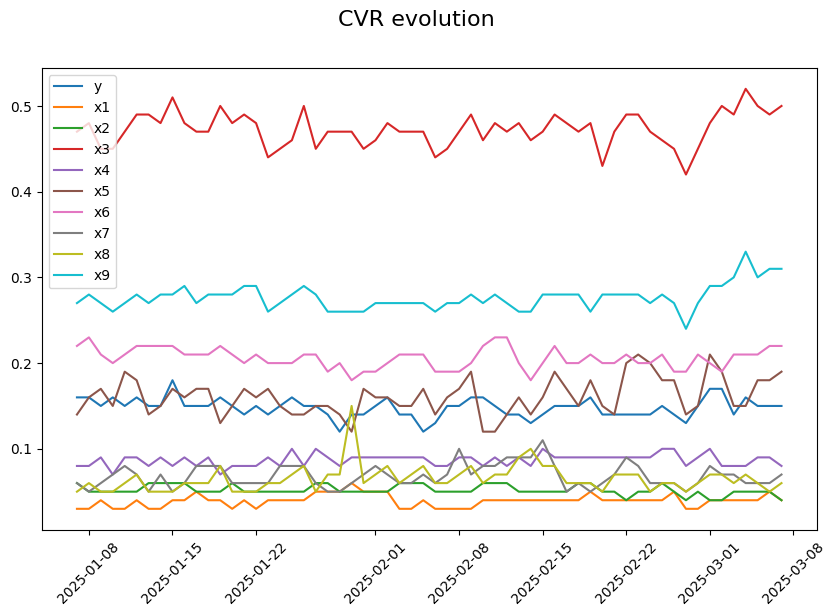

[('ctr_sum_MyAuchan', 'y'),
 ("ctr_sum_Ben & Jerry's", 'x1'),
 ('ctr_sum_Celeiro', 'x2'),
 ('ctr_sum_Continente', 'x3'),
 ('ctr_sum_Galp Conveniência', 'x4'),
 ('ctr_sum_Loja de Conveniência', 'x5'),
 ('ctr_sum_Minipreço', 'x6'),
 ('ctr_sum_NOS Cinemas', 'x7'),
 ('ctr_sum_O Melhor Croissant da Minha Rua', 'x8'),
 ('ctr_sum_Pingo Doce', 'x9'),
 ('ctr_sum_Supermercado El Corte Inglés', 'x10')]

In [12]:
v = dataframe_visualizer.DataFrameVisualizer(scm_data.reset_index())

plot_params = [
    {
        "plot_type": "lineplot",
        "x_column": "p_creation_date",
        "y_columns": ["y","x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9"],
        "legend": True,
        },
]

figure_params = {
    'n_plots': 1,
    'fig_length': 10,
    'fig_height': 6,
    'x_rotation': 45,
    'share_x': False,
    'share_y': False,
    'x_limits': None, # [(0,100),(0,1000)]
    'y_limits': None, # [(0,100),(0,1000)]
    'log_axis': None, # 'x', 'y', 'both'
    'title': 'CVR evolution'
}

# Call the plot method to handle the entire flow
v.plot(
    figure_params=figure_params,
    plot_params=plot_params
)

scm_columns


 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28181D+00    |proj g|=  2.94667D-01

At iterate    5    f=  1.18677D+00    |proj g|=  4.97587D-02

At iterate   10    f=  1.18526D+00    |proj g|=  2.47364D-03

At iterate   15    f=  1.18525D+00    |proj g|=  2.02690D-04

At iterate   20    f=  1.18525D+00    |proj g|=  1.89972D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     20     26      1     0     0   1.900D-05   1.185D+00
  F =   1.1852541862389554     

CONVERG

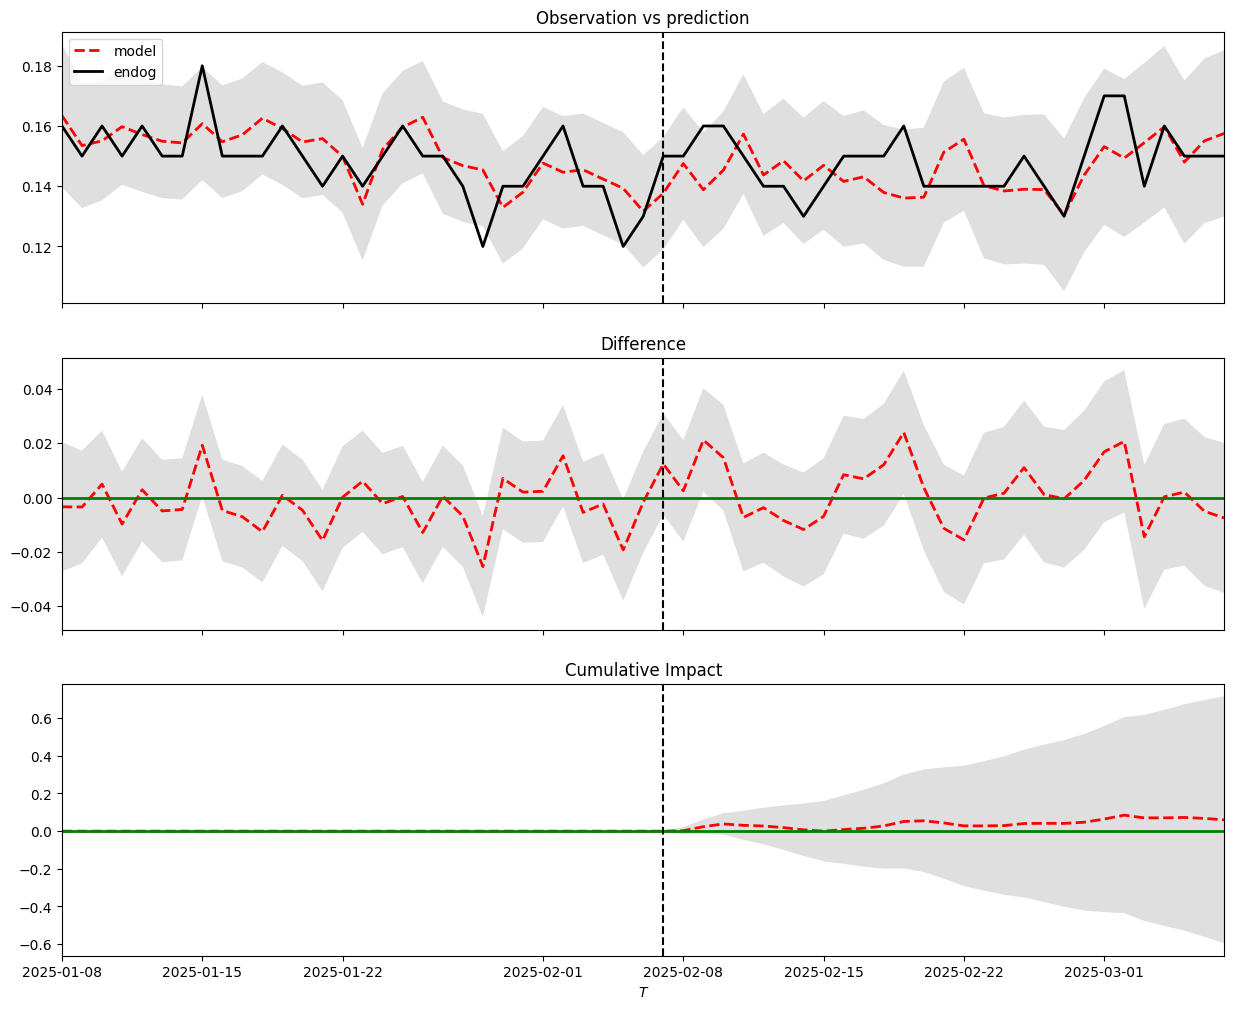

In [13]:
START_DATE = "2025-01-07"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2025-02-07"
POST_TREATMENT_DATE = "2025-02-08"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()



In [18]:
# Group by store_name, and sum the impressions, accessed and orders
df.groupby('store_name').agg({'impressions': 'sum', 'accessed': 'sum', 'orders': 'sum'}).reset_index().sort_values('impressions', ascending=False)

,store_name,impressions,accessed,orders
3,Continente,929328,439813,147341
6,Minipreço,849027,173948,45031
2,Celeiro,621611,31593,5063
0,Auchan,576358,97743,18459
9,O Melhor Croissant da Minha Rua,563028,37640,7374
1,Ben & Jerry's,562286,22050,2464
10,Pingo Doce,526163,145658,42822
11,Supermercado El Corte Inglés,425050,27634,4305
8,NOS Cinemas,280698,20097,2379
4,Galp Conveniência,241281,20809,2281


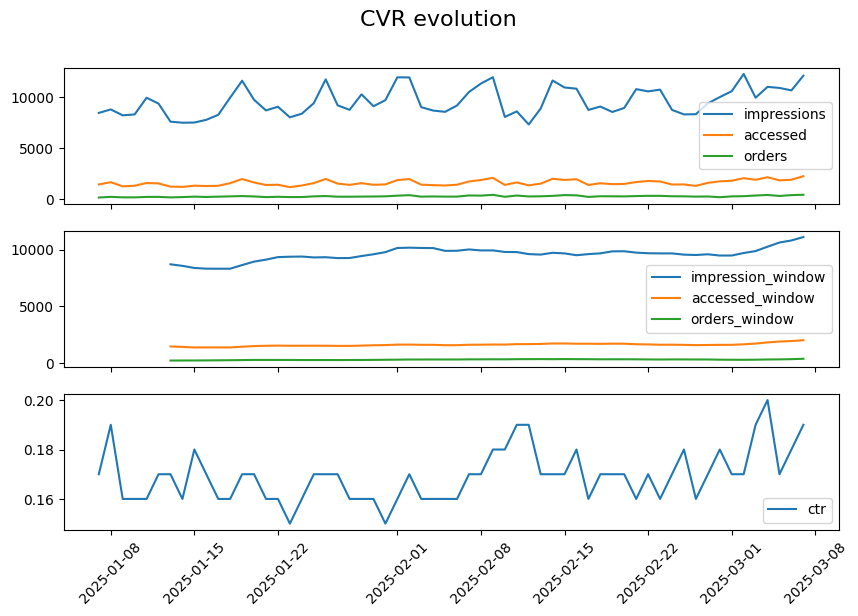

[('ctr_sum_MyAuchan', 'y'),
 ("ctr_sum_Ben & Jerry's", 'x1'),
 ('ctr_sum_Celeiro', 'x2'),
 ('ctr_sum_Continente', 'x3'),
 ('ctr_sum_Galp Conveniência', 'x4'),
 ('ctr_sum_Loja de Conveniência', 'x5'),
 ('ctr_sum_Minipreço', 'x6'),
 ('ctr_sum_NOS Cinemas', 'x7'),
 ('ctr_sum_O Melhor Croissant da Minha Rua', 'x8'),
 ('ctr_sum_Pingo Doce', 'x9'),
 ('ctr_sum_Supermercado El Corte Inglés', 'x10')]

In [54]:
PARTNER_NAME = 'Auchan'
cond = df['store_name'] == PARTNER_NAME
df['p_creation_date'] = pd.to_datetime(df['p_creation_date'])

tmp_df = df[cond].copy()

tmp_df.sort_values('p_creation_date', inplace=True)

# Rolling average of last X days
X = 7
tmp_df['impression_window'] = tmp_df['impressions'].rolling(window=X).mean()
tmp_df['accessed_window'] = tmp_df['accessed'].rolling(window=X).mean()
tmp_df['orders_window'] = tmp_df['orders'].rolling(window=X).mean()

v = dataframe_visualizer.DataFrameVisualizer(tmp_df)

plot_params = [
    {
    "plot_type": "lineplot",
    "x_column": "p_creation_date",
    "y_columns": ["impressions", "accessed", "orders"],
    "legend": True,
    },
    {
    "plot_type": "lineplot",
    "x_column": "p_creation_date",
    "y_columns": ["impression_window", "accessed_window", "orders_window"],
    "legend": True,
    },
    {
    "plot_type": "lineplot",
    "x_column": "p_creation_date",
    "y_columns": ["ctr"],
    "legend": True,
    },
]

figure_params = {
    'n_plots': 3,
    'fig_length': 10,
    'fig_height': 6,
    'x_rotation': 45,
    'share_x': True,
    'share_y': False,
    'x_limits': None, # [(0,100),(0,1000)]
    'y_limits': None, # [(0,100),(0,1000)]
    'log_axis': None, # 'x', 'y', 'both'
    'title': 'CVR evolution'
}

# Call the plot method to handle the entire flow
v.plot(
    figure_params=figure_params,
    plot_params=plot_params
)

scm_columns


# MA Marjane

In [9]:
QUERY_NAME = "time_series.sql"  # With sql
START_DATE = "'2024-10-19'"
END_DATE = "'2025-01-22'"
COUNTRY = "'MA'"
NAME_CONDITION = "(s.store_name = 'Marjane' or s.store_name = 'Marjane Hyper' or s.store_name = 'Marjane')"
SYNTHETIC_GROUP = 20

params = [
    {"name": "start_date", "value": str(START_DATE)},
    {"name": "end_date", "value": str(END_DATE)},
    {"name": "country", "value": str(COUNTRY)},
    {"name": "name_condition", "value": str(NAME_CONDITION)},
    {"name": "synthetic_group", "value": str(SYNTHETIC_GROUP)},
]

q.prepare_query(QUERY_NAME, params=params, output_file='MA_Marjane', load_previous=False)

df = q.query_run_starburst()
df.head()


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/f179529363ae430501a49fe05749e0a5b9a39643b553c85603eb2df5290a5a04


,p_creation_date,store_name,is_target,rank,impressions,accessed,orders,ctr,cvr
0,2024-11-18,Carrefour Market,0,1,20767,8956,3209,0.43,0.15
1,2024-11-06,LES DOMAINES,0,13,3521,482,109,0.14,0.03
2,2024-12-24,Maymana Bakery,0,20,4829,760,85,0.16,0.02
3,2024-11-09,Carrefour Hyper,0,3,9087,2905,691,0.32,0.08
4,2024-12-14,Carrefour Gourmet,0,6,5807,1096,307,0.19,0.05


In [11]:
# Group by store_name, and sum the impressions, accessed and orders
df.groupby('store_name').agg({'impressions': 'sum', 'accessed': 'sum', 'orders': 'sum'}).reset_index().sort_values('impressions', ascending=False)

,store_name,impressions,accessed,orders
3,Carrefour Market,2125508,841418,272070
17,PAUL,1790519,367620,96715
0,Carrefour Express,1368071,241517,48478
12,Marjane,1367008,475357,96691
2,Carrefour Hyper,795504,238571,53668
16,Oliveri,701131,62139,12201
11,Les Quatre Cerises,674069,152417,31777
4,Carrefour Market By Night,667780,66417,11793
6,Donuts Factory,589315,34626,5052
1,Carrefour Gourmet,554633,100129,24619


## Marjane

In [12]:
# Pivot dataframe
NOT_Y = ['Marjane Market', 'Marjane Hyper']
T = 'p_creation_date'
Y = 'ctr_sum_Marjane'

df_filtered = df[~df['store_name'].isin(NOT_Y)].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
p_creation_date,,,,,,,,,,,,,,,,,,,,
2024-10-19,0.33,0.18,0.20,0.32,0.42,0.10,0.15,0.06,0.13,0.17,0.11,0.12,0.24,0.14,0.11,0.22,0.16,0.10,0.19,0.14
2024-10-20,0.34,0.19,0.20,0.32,0.43,0.09,0.15,0.06,0.14,0.18,0.10,0.10,0.24,0.14,0.10,0.23,0.18,0.10,0.20,0.15
2024-10-21,0.34,0.19,0.19,0.31,0.43,0.11,0.14,0.06,0.15,0.13,0.12,0.13,0.22,0.14,0.08,0.20,0.16,0.12,0.17,0.14
2024-10-22,0.35,0.20,0.21,0.32,0.43,0.11,0.15,0.06,0.15,0.16,0.12,0.13,0.22,0.14,0.09,0.20,0.17,0.11,0.16,0.13
2024-10-23,0.34,0.18,0.19,0.30,0.42,0.10,0.15,0.06,0.13,0.15,0.12,0.14,0.22,0.14,0.09,0.20,0.15,0.11,0.17,0.14


In [23]:
scm_data.drop(columns='x13', inplace=True)

 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07696D+00    |proj g|=  4.19141D-01

At iterate    5    f=  9.18857D-01    |proj g|=  2.24996D-01

At iterate   10    f=  8.99756D-01    |proj g|=  1.94956D-02

At iterate   15    f=  8.98987D-01    |proj g|=  5.40310D-03

At iterate   20    f=  8.98964D-01    |proj g|=  8.75205D-04

At iterate   25    f=  8.98963D-01    |proj g|=  2.99031D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     25     33      1     0     0   

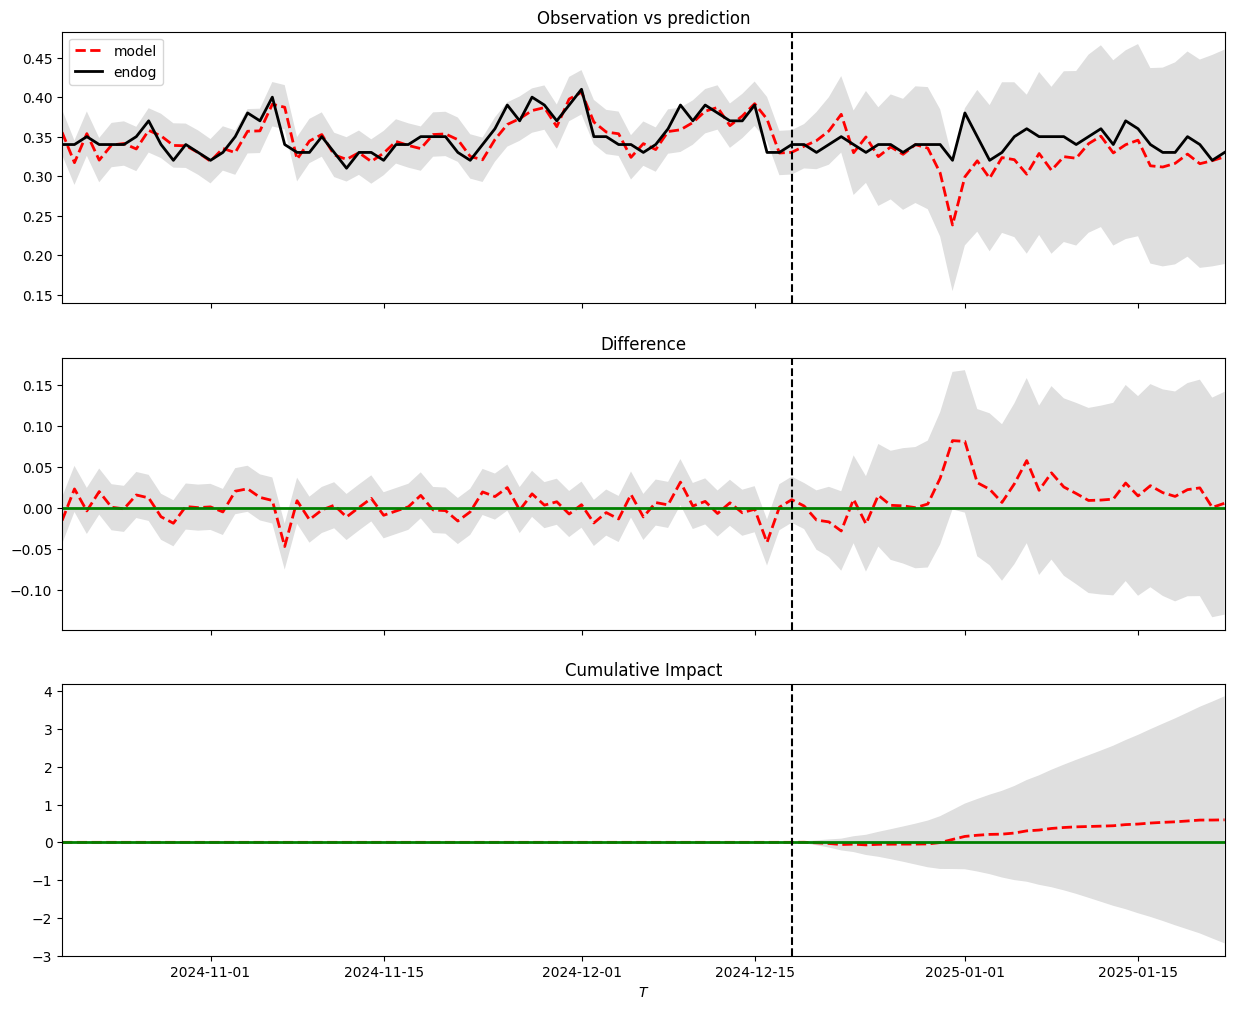

In [31]:
START_DATE = "2024-10-19"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2024-12-18"
POST_TREATMENT_DATE = "2024-12-19"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()

## Marjane Market

In [32]:
# Pivot dataframe
NOT_Y = ['Marjane', 'Marjane Hyper']
T = 'p_creation_date'
Y = 'ctr_sum_Marjane Market'

df_filtered = df[~df['store_name'].isin(NOT_Y)].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
p_creation_date,,,,,,,,,,,,,,,,,,,,
2024-10-19,0.35,0.18,0.20,0.32,0.42,0.10,0.15,0.06,0.13,0.17,0.11,0.12,0.24,0.14,0.11,0.22,0.16,0.10,0.19,0.14
2024-10-20,0.36,0.19,0.20,0.32,0.43,0.09,0.15,0.06,0.14,0.18,0.10,0.10,0.24,0.14,0.10,0.23,0.18,0.10,0.20,0.15
2024-10-21,0.34,0.19,0.19,0.31,0.43,0.11,0.14,0.06,0.15,0.13,0.12,0.13,0.22,0.14,0.08,0.20,0.16,0.12,0.17,0.14
2024-10-22,0.35,0.20,0.21,0.32,0.43,0.11,0.15,0.06,0.15,0.16,0.12,0.13,0.22,0.14,0.09,0.20,0.17,0.11,0.16,0.13
2024-10-23,0.37,0.18,0.19,0.30,0.42,0.10,0.15,0.06,0.13,0.15,0.12,0.14,0.22,0.14,0.09,0.20,0.15,0.11,0.17,0.14


In [34]:
scm_data.drop(columns='x13', inplace=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27942D+00    |proj g|=  2.01428D-01

At iterate    5    f=  1.24834D+00    |proj g|=  5.79719D-02

At iterate   10    f=  1.23877D+00    |proj g|=  1.49697D-02

At iterate   15    f=  1.23836D+00    |proj g|=  8.88676D-04

At iterate   20    f=  1.23836D+00    |proj g|=  1.15244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     23     28      1     0     0   1.465D-05   1.238D+00
  F =   1.2383584163940551     

CONVERG

 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


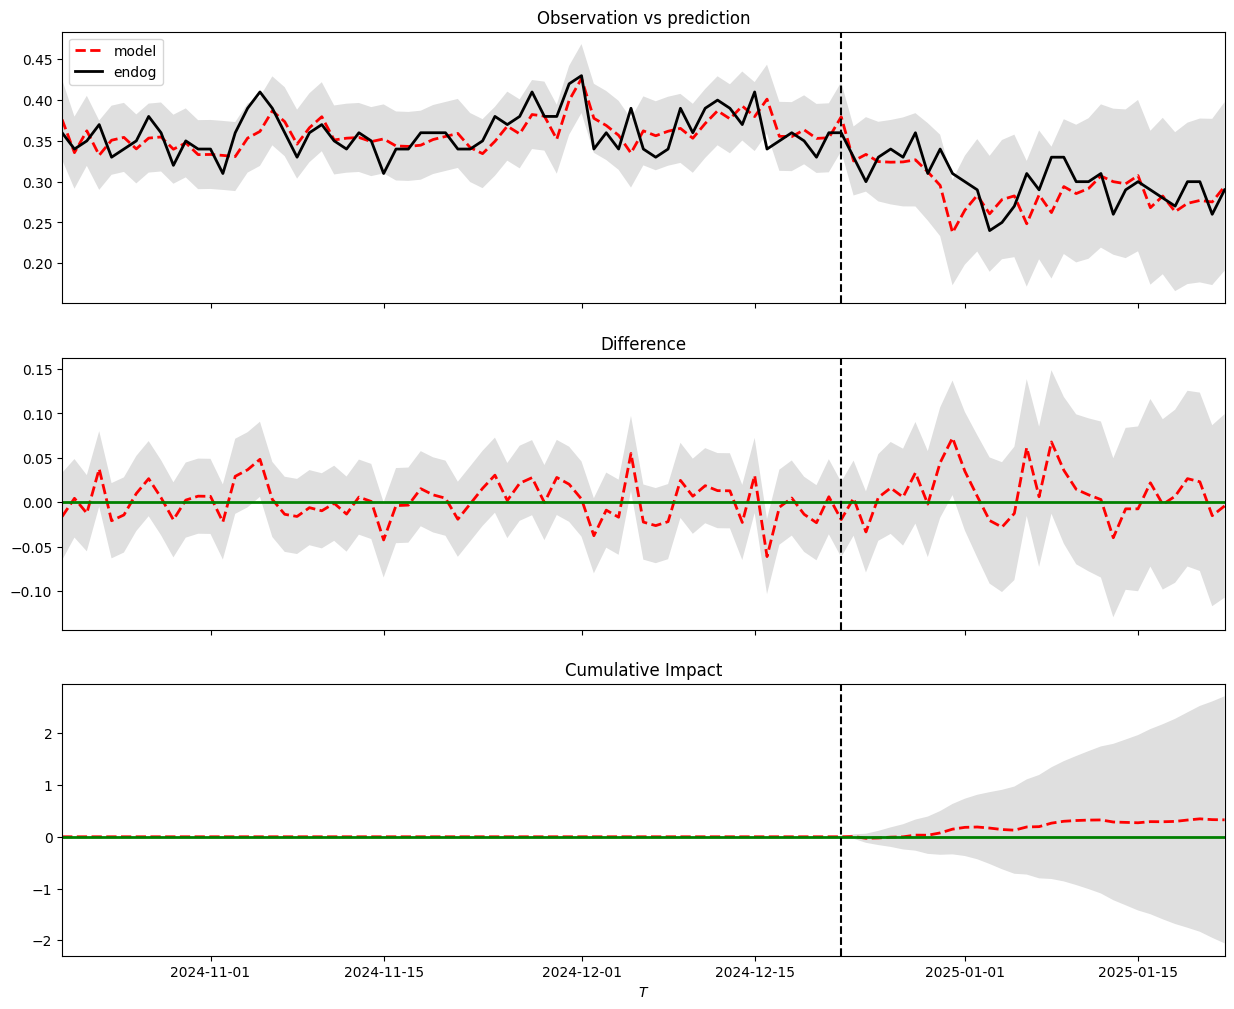

In [35]:
START_DATE = "2024-10-19"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2024-12-22"
POST_TREATMENT_DATE = "2024-12-23"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()

# ES Supermercado MAS

In [61]:
QUERY_NAME = "time_series.sql"  # With sql
START_DATE = "'2024-05-25'"
END_DATE = "'2024-08-26'"
COUNTRY = "'ES'"
NAME_CONDITION = "(s.store_name = 'Supermercados MAS')"
SYNTHETIC_GROUP = 20

params = [
    {"name": "start_date", "value": str(START_DATE)},
    {"name": "end_date", "value": str(END_DATE)},
    {"name": "country", "value": str(COUNTRY)},
    {"name": "name_condition", "value": str(NAME_CONDITION)},
    {"name": "synthetic_group", "value": str(SYNTHETIC_GROUP)},
]

q.prepare_query(QUERY_NAME, params=params, output_file='ES_Supermercado MAS', load_previous=False)

df = q.query_run_starburst()
df.head()


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/0261219be54eb3df577892ba0cccfa57dbc8c9b062c2344ab1db20e27d4efbcd


,p_creation_date,store_name,is_target,rank,impressions,accessed,orders,ctr,cvr
0,2024-06-08,Santagloria,0,20,17889,1470,183,0.08,0.01
1,2024-06-13,Carrefour,0,2,17360,4190,909,0.24,0.05
2,2024-08-09,Ametller Origen,0,7,8237,1205,396,0.15,0.05
3,2024-08-24,Ametller Origen,0,7,8631,1285,437,0.15,0.05
4,2024-07-23,Condis,0,6,8417,1971,725,0.23,0.09


In [62]:
# Group by store_name, and sum the impressions, accessed and orders
df.groupby('store_name').agg({'impressions': 'sum', 'accessed': 'sum', 'orders': 'sum'}).reset_index().sort_values('impressions', ascending=False)

,store_name,impressions,accessed,orders
15,Supermercado DIA,3291532,1138122,473145
3,Carrefour,1989525,510465,119324
10,Manolo Bakes,1815486,170407,37348
9,Levaduramadre,1594441,127894,20191
0,Alcampo,1434315,345664,87771
18,Tu Tienda Repsol,1321261,158418,18071
13,Santagloria,1221242,105634,12162
20,llaollao,1050336,76224,14540
8,La Sirena,964378,103235,16986
6,Eroski,847623,215728,77819


In [63]:
# Pivot dataframe
NOT_Y = ['XXX']
T = 'p_creation_date'
Y = 'ctr_sum_Supermercados MAS'

df_filtered = df[~df['store_name'].isin(NOT_Y)].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20
p_creation_date,,,,,,,,,,,,,,,,,,,,,
2024-05-25,0.25,0.27,0.21,0.25,0.25,0.22,0.21,0.26,0.49,0.14,...,0.10,0.36,0.18,0.10,0.17,0.35,0.12,0.12,0.11,0.08
2024-05-26,0.23,0.22,0.16,0.23,0.27,0.22,0.14,0.23,0.42,0.08,...,0.11,0.40,0.20,0.12,0.11,0.23,0.18,0.22,0.09,0.09
2024-05-27,0.31,0.29,0.26,0.26,0.28,0.23,0.25,0.27,0.49,0.13,...,0.11,0.32,0.22,0.10,0.16,0.39,0.10,0.11,0.13,0.07
2024-05-28,0.31,0.28,0.24,0.26,0.27,0.24,0.23,0.26,0.49,0.15,...,0.11,0.35,0.21,0.11,0.18,0.38,0.12,0.11,0.13,0.08
2024-05-29,0.29,0.28,0.22,0.25,0.26,0.23,0.24,0.25,0.48,0.13,...,0.10,0.33,0.21,0.10,0.17,0.38,0.12,0.11,0.12,0.08


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53463D-01    |proj g|=  6.86319D-01

At iterate    5    f=  5.52519D-01    |proj g|=  1.69971D-01

At iterate   10    f=  5.21941D-01    |proj g|=  9.44531D-02

At iterate   15    f=  4.89882D-01    |proj g|=  1.68380D-01

At iterate   20    f=  4.83222D-01    |proj g|=  4.26943D-02

At iterate   25    f=  4.78568D-01    |proj g|=  2.33779D-02

At iterate   30    f=  4.76886D-01    |proj g|=  2.61351D-02

At iterate   35    f=  4.76439D-01    |proj g|=  1.66668D-02

At iterate   40    f=  4.76056D-01    |proj g|=  4.19934D-02

At iterate   45    f=  4.75907D-01    |proj g|=  1.02535D-02

At iterate   50    f=  4.75856D-01    |proj g|=  3.67000D-03

At iterate   55    f=  4.75840D-01    |proj g|=  1.02964D-03

At iterate   60    f=  4.75837D-01    |proj g|=  1.05346D-03

At iterate   65    f=  4.7

 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


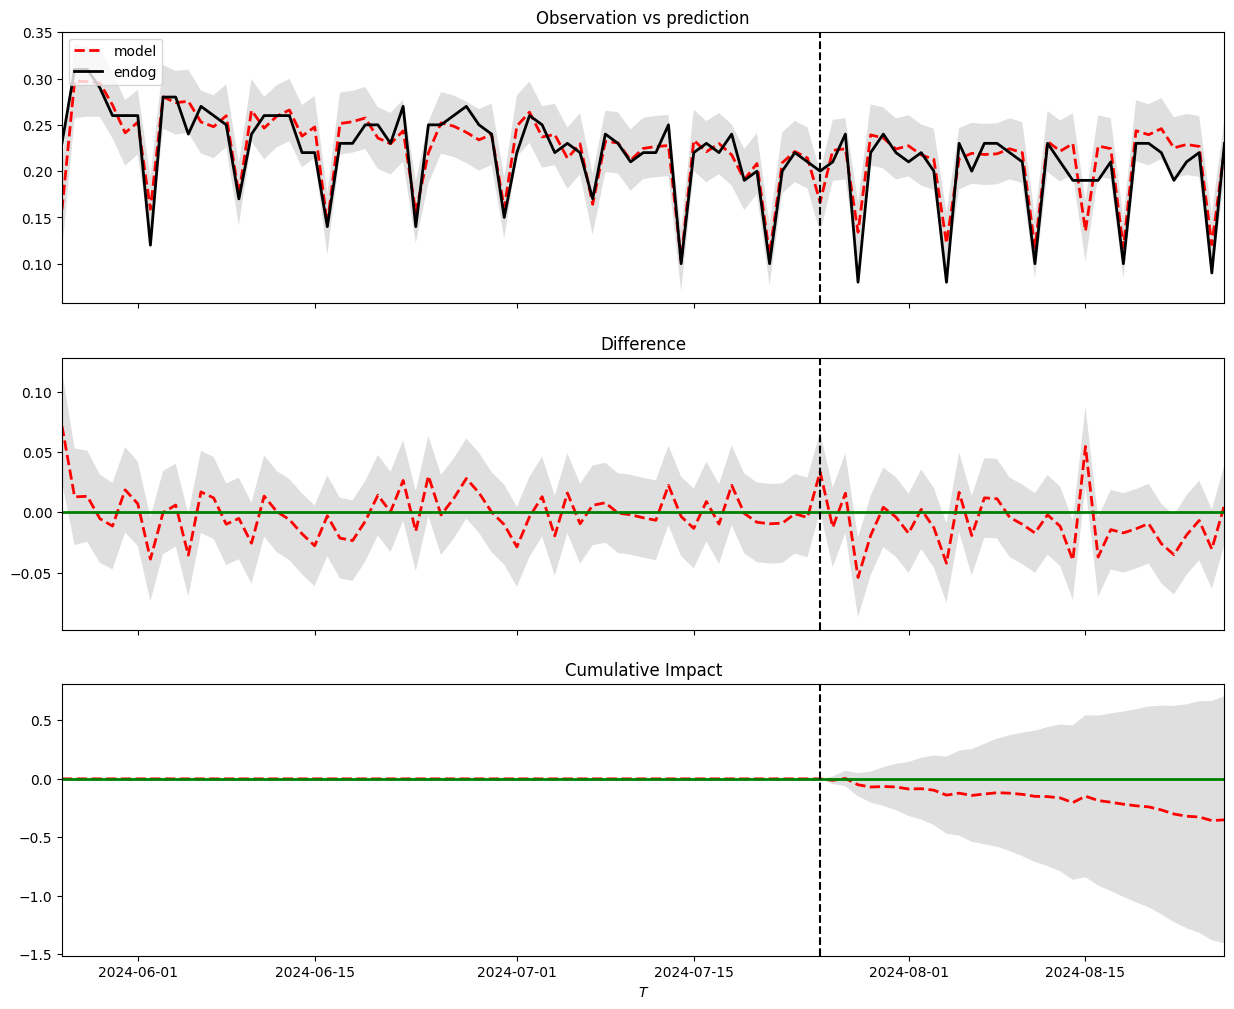

In [64]:
START_DATE = "2024-05-25"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2024-07-25"
POST_TREATMENT_DATE = "2024-07-26"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()

# RS Mercator

In [77]:
QUERY_NAME = "time_series.sql"  # With sql
START_DATE = "'2024-03-24'"
END_DATE = "'2024-06-24'"
COUNTRY = "'RS'"
NAME_CONDITION = "(s.store_name = 'IDEA')"
SYNTHETIC_GROUP = 20

params = [
    {"name": "start_date", "value": str(START_DATE)},
    {"name": "end_date", "value": str(END_DATE)},
    {"name": "country", "value": str(COUNTRY)},
    {"name": "name_condition", "value": str(NAME_CONDITION)},
    {"name": "synthetic_group", "value": str(SYNTHETIC_GROUP)},
]

q.prepare_query(QUERY_NAME, params=params, output_file='RS_IDEA', load_previous=False)

df = q.query_run_starburst()
df.head()


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/762bccbc802e656ac04b803e7396e08ad93a6cbed9dda9faadef469f2cb5f558


,p_creation_date,store_name,is_target,rank,impressions,accessed,orders,ctr,cvr
0,2024-06-17,DIS Supermarket,0,2,1419,348,61,0.25,0.04
1,2024-05-28,Maxi,0,1,2149,583,87,0.27,0.04
2,2024-05-30,Gomex,0,12,645,103,9,0.16,0.01
3,2024-05-07,Štark shop,0,16,893,62,2,0.07,0.00
4,2024-04-15,Univerexport,0,4,1387,286,37,0.21,0.03


In [78]:
# Group by store_name, and sum the impressions, accessed and orders
df.groupby('store_name').agg({'impressions': 'sum', 'accessed': 'sum', 'orders': 'sum'}).reset_index().sort_values('impressions', ascending=False)

,store_name,impressions,accessed,orders
6,IDEA,253521,76533,17302
10,Maxi,211293,57819,8121
0,Aman,182110,27746,3539
4,DIS Supermarket,162338,34498,4036
18,Univerexport,125812,25763,3001
1,Aroma City,125518,18423,3940
7,IDEA Organic,108483,12682,1558
8,Kiosk 3M - Samo sekund,89046,17493,3532
20,Štark shop,67504,4845,289
5,Gomex,60460,7964,407


In [79]:
# Pivot dataframe
NOT_Y = ['XXX']
T = 'p_creation_date'
Y = 'ctr_sum_IDEA'

df_filtered = df[~df['store_name'].isin(NOT_Y)].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20
p_creation_date,,,,,,,,,,,,,,,,,,,,,
2024-03-24,0.28,0.15,0.15,0.12,0.11,0.26,0.12,0.16,0.18,0.12,...,0.28,0.11,0.05,0.07,0.08,0.05,0.07,NaN,0.03,0.07
2024-03-25,0.31,0.16,0.16,0.11,0.10,0.25,0.15,0.19,0.18,0.20,...,0.27,0.11,0.06,0.09,0.09,0.10,0.11,0.33,0.04,0.06
2024-03-26,0.30,0.17,0.16,0.14,0.10,0.25,0.13,0.17,0.19,0.17,...,0.25,0.08,0.05,0.08,0.11,0.06,0.08,0.33,0.05,0.08
2024-03-27,0.32,0.15,0.13,0.16,0.09,0.24,0.13,0.16,0.19,0.23,...,0.35,0.10,0.07,0.11,0.06,0.10,0.08,0.28,0.07,0.08
2024-03-28,0.21,0.10,0.10,0.09,0.10,0.28,0.12,0.10,0.10,0.18,...,0.22,0.07,0.05,0.08,0.07,0.07,0.13,0.16,0.05,0.07


In [81]:
scm_data.drop(columns='x18', inplace=True)
scm_data.isnull().sum()

y      0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x19    0
x20    0
dtype: int64

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87329D-01    |proj g|=  6.43900D-01

At iterate    5    f=  5.89723D-01    |proj g|=  2.64981D-01

At iterate   10    f=  5.70702D-01    |proj g|=  4.78097D-02

At iterate   15    f=  5.69614D-01    |proj g|=  3.33496D-03

At iterate   20    f=  5.69602D-01    |proj g|=  3.10934D-04

At iterate   25    f=  5.69602D-01    |proj g|=  3.86823D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     25     33      1     0     0   

 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


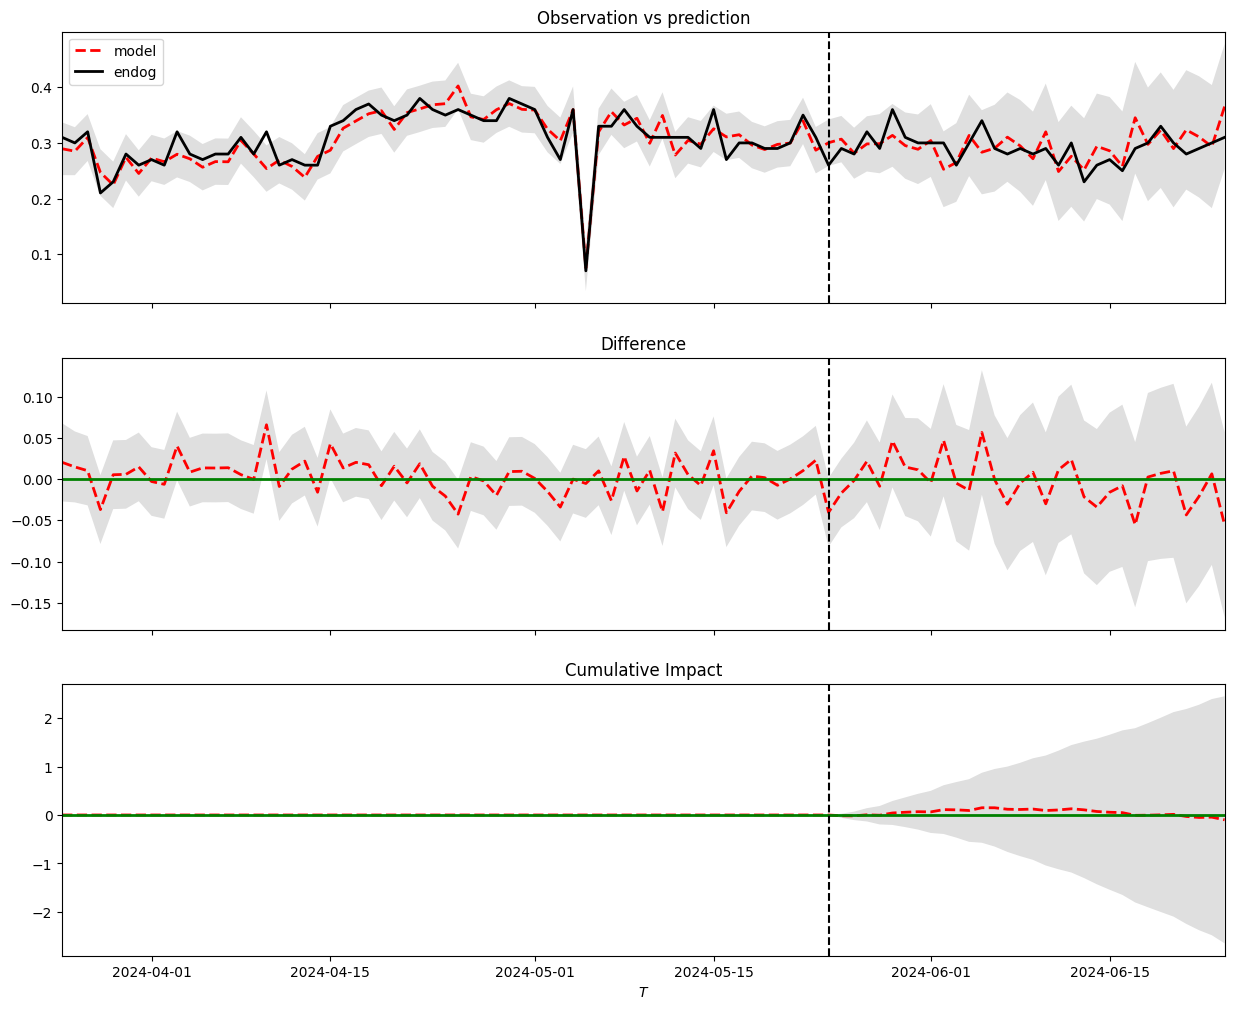

In [82]:
START_DATE = "2024-03-24"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2024-05-24"
POST_TREATMENT_DATE = "2024-05-25"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()

# BG Kaufland

In [83]:
QUERY_NAME = "time_series.sql"  # With sql
START_DATE = "'2024-01-08'"
END_DATE = "'2024-04-08'"
COUNTRY = "'BG'"
NAME_CONDITION = "(s.store_name = 'Kaufland')"
SYNTHETIC_GROUP = 20

params = [
    {"name": "start_date", "value": str(START_DATE)},
    {"name": "end_date", "value": str(END_DATE)},
    {"name": "country", "value": str(COUNTRY)},
    {"name": "name_condition", "value": str(NAME_CONDITION)},
    {"name": "synthetic_group", "value": str(SYNTHETIC_GROUP)},
]

q.prepare_query(QUERY_NAME, params=params, output_file='BG_Kaufland', load_previous=False)

df = q.query_run_starburst()
df.head()


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/b014af7ae9cef3270157e549bbe2ac2651f88a139cc19edd67a4811d56c21a95


,p_creation_date,store_name,is_target,rank,impressions,accessed,orders,ctr,cvr
0,2024-02-16,BILLA,0,1,1619,599,136,0.37,0.08
1,2024-03-15,Фантазия,0,10,134,28,6,0.21,0.04
2,2024-03-01,Ice Cream Heaven,0,18,614,33,3,0.05,0.00
3,2024-02-16,Carrefour,0,3,975,161,23,0.17,0.02
4,2024-02-18,CBA Kome,0,5,1176,149,13,0.13,0.01


In [84]:
# Group by store_name, and sum the impressions, accessed and orders
df.groupby('store_name').agg({'impressions': 'sum', 'accessed': 'sum', 'orders': 'sum'}).reset_index().sort_values('impressions', ascending=False)

,store_name,impressions,accessed,orders
8,Kaufland,246489,100264,19896
2,BILLA,180164,68978,18165
11,Берёзка,130138,15764,1738
6,Glovo Drinks,111477,4784,491
4,CBA Kome,91624,11841,1258
5,Carrefour,89251,17311,2898
3,Balev Bio Market,80274,6728,283
7,Ice Cream Heaven,61910,2653,199
16,Плод и зеленчук Флора,50792,2810,339
0,Alcohol & Tobacco 24/7,48666,5514,1105


In [85]:
# Pivot dataframe
NOT_Y = ['XXX']
T = 'p_creation_date'
Y = 'ctr_sum_Kaufland'

df_filtered = df[~df['store_name'].isin(NOT_Y)].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20
p_creation_date,,,,,,,,,,,,,,,,,,,,,
2024-01-08,0.45,0.12,0.31,0.37,0.09,0.12,0.19,0.03,0.03,0.05,...,0.12,0.18,0.07,0.06,0.05,0.06,0.09,0.21,0.28,0.38
2024-01-09,0.45,0.11,0.26,0.33,0.08,0.13,0.22,0.04,0.03,0.09,...,0.11,0.19,0.09,0.06,0.05,0.07,0.15,0.21,0.28,0.38
2024-01-10,0.40,0.11,0.30,0.33,0.07,0.10,0.18,0.04,0.03,0.13,...,0.13,0.19,0.09,0.04,0.06,0.04,0.16,0.27,0.32,0.34
2024-01-11,0.40,0.11,0.23,0.37,0.08,0.11,0.18,0.04,0.04,0.08,...,0.11,0.11,0.10,0.07,0.06,0.07,0.13,0.15,0.30,0.35
2024-01-12,0.38,0.13,0.28,0.33,0.08,0.12,0.20,0.05,0.05,0.09,...,0.09,0.12,0.11,0.06,0.06,0.04,0.11,0.11,0.27,0.33


In [88]:
scm_data.drop(columns='x20', inplace=True)

 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53438D-01    |proj g|=  3.86045D-01

At iterate    5    f=  8.65069D-01    |proj g|=  3.04454D-02

At iterate   10    f=  8.64113D-01    |proj g|=  1.59907D-03

At iterate   15    f=  8.64107D-01    |proj g|=  1.40802D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     18     23      1     0     0   3.441D-05   8.641D-01
  F =  0.86410685536755050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


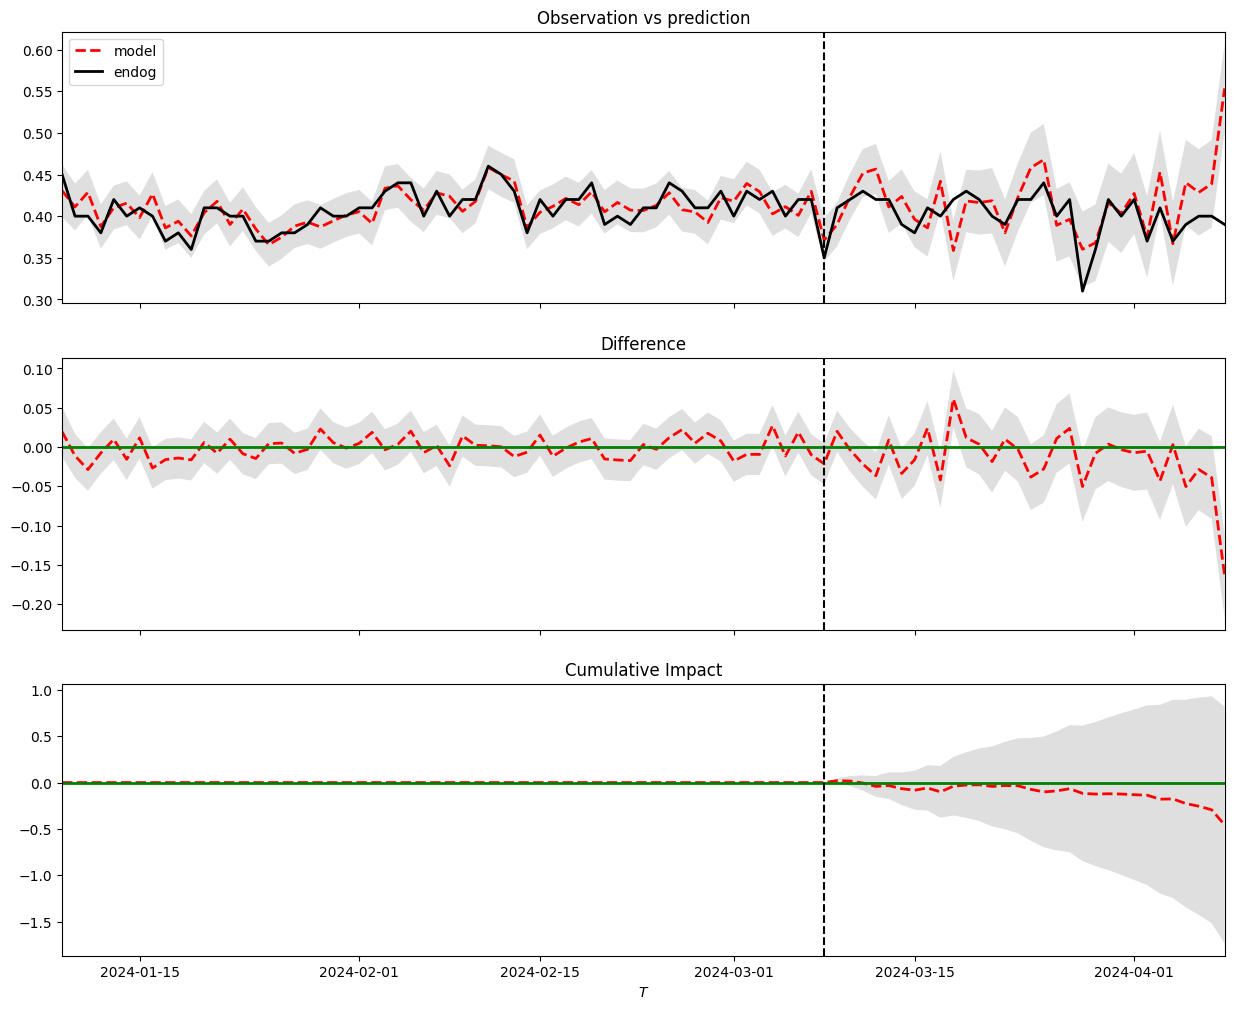

In [89]:
START_DATE = "2024-01-08"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2024-03-08"
POST_TREATMENT_DATE = "2024-03-09"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()

# PL Biedronka

In [96]:
QUERY_NAME = "time_series.sql"  # With sql
START_DATE = "'2024-01-08'"
END_DATE = "'2024-04-08'"
COUNTRY = "'PL'"
NAME_CONDITION = "(s.store_name = 'Sklep Internetowy Biedronka')"
SYNTHETIC_GROUP = 20

params = [
    {"name": "start_date", "value": str(START_DATE)},
    {"name": "end_date", "value": str(END_DATE)},
    {"name": "country", "value": str(COUNTRY)},
    {"name": "name_condition", "value": str(NAME_CONDITION)},
    {"name": "synthetic_group", "value": str(SYNTHETIC_GROUP)},
]

q.prepare_query(QUERY_NAME, params=params, output_file='BG_Kaufland', load_previous=False)

df = q.query_run_starburst()
df.head()


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/f81fb3ae4cb50fb558ecad6abaefa2923da7bb85e82d3ab303d511bb2c979bd8


,p_creation_date,store_name,is_target,rank,impressions,accessed,orders,ctr,cvr
0,2024-01-29,Sklep bp,0,8,4621,534,108,0.12,0.02
1,2024-03-26,Biedronka,0,2,11531,5562,1126,0.48,0.10
2,2024-01-23,Duży Ben,0,5,10232,1336,373,0.13,0.04
3,2024-02-19,Party Express,0,12,3530,280,28,0.08,0.01
4,2024-02-20,Delikatesy Organic,0,18,1264,138,8,0.11,0.01


In [97]:
# Group by store_name, and sum the impressions, accessed and orders
df.groupby('store_name').agg({'impressions': 'sum', 'accessed': 'sum', 'orders': 'sum'}).reset_index().sort_values('impressions', ascending=False)

,store_name,impressions,accessed,orders
4,Biedronka,1341738,652583,141418
11,Lody Ice Cream Now,1122301,62388,6109
6,Carrefour,1077951,333850,66124
9,Duży Ben,1022649,157569,44027
3,Auchan,1013534,382652,98557
7,Circle K,802275,98100,15204
14,Piwniczka Biedronki,718237,123454,8248
5,Biedronka Express,668174,301491,82350
18,Sklep bp,506143,74153,15009
12,Market bp,392876,53848,10638


In [98]:
# Pivot dataframe
NOT_Y = ['Skep Internetowy Biedronka', 'Biedronka Express'] 
T = 'p_creation_date'
Y = 'ctr_sum_Biedronka'

df_filtered = df[~df['store_name'].isin(NOT_Y)].copy()
dp = dataframe_pivot.DataFramePivot(df_filtered)

TIME = "p_creation_date"
DIMENSIONS = ["store_name"]
MEASURES = ["ctr"]
AFFUNCS = ["sum"]

# Call the pivot_and_aggregate method
p = dp.pivot_and_aggregate(
    t=TIME, dimensions=DIMENSIONS, measures=MEASURES, aggfuncs=AFFUNCS
)

# Prepare scm dataset
scm = dataframe_synthetic_control_preparation.DataframeSyntheticControlPreparation(p)
scm_data, scm_columns = scm.prepare_synthetic_control(T,Y)
scm_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
p_creation_date,,,,,,,,,,,,,,,,,,,,
2024-01-08,0.59,0.08,0.08,0.06,0.46,0.36,0.08,0.08,0.10,0.12,0.04,0.09,0.09,0.31,0.05,0.14,NaN,0.10,0.10,0.07
2024-01-09,0.55,0.10,0.09,0.08,0.43,0.34,0.09,0.10,0.11,0.16,0.04,0.10,0.09,0.29,0.08,0.14,NaN,0.10,0.11,0.09
2024-01-10,0.52,0.10,0.07,0.09,0.42,0.32,0.09,0.08,0.11,0.15,0.04,0.10,0.08,0.28,0.09,0.17,0.0,0.11,0.10,0.11
2024-01-11,0.54,0.12,0.10,0.11,0.42,0.33,0.09,0.10,0.13,0.20,0.04,0.11,0.08,0.29,0.11,0.17,0.0,0.12,0.09,0.11
2024-01-12,0.53,0.10,0.13,0.10,0.44,0.32,0.09,0.07,0.15,0.14,0.04,0.11,0.10,0.31,0.11,0.16,0.0,0.11,0.09,0.14


In [104]:
scm_data.isnull().sum()
# scm_data.drop(columns='x3', inplace=True)
# scm_data.drop(columns='x4', inplace=True)
# scm_data.drop(columns='x9', inplace=True)
# scm_data.drop(columns='x15', inplace=True)
# scm_data.drop(columns='x16', inplace=True)
# scm_data.drop(columns='x5', inplace=True)


y      0
x1     0
x2     0
x6     0
x7     0
x8     0
x10    0
x11    0
x12    0
x13    0
x14    0
x17    0
x18    0
x19    0
dtype: int64

 This problem is unconstrained.
/Users/jordicremades/Documents/repos/thoth/analysis/instore_prices_synthetic_control_method_2025/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48353D-01    |proj g|=  6.96765D-01

At iterate    5    f=  5.61545D-01    |proj g|=  3.17269D-01

At iterate   10    f=  4.44862D-01    |proj g|=  1.99606D-01

At iterate   15    f=  4.08844D-01    |proj g|=  5.43178D-02

At iterate   20    f=  4.02806D-01    |proj g|=  4.67410D-02

At iterate   25    f=  4.01378D-01    |proj g|=  1.34106D-02

At iterate   30    f=  4.01245D-01    |proj g|=  8.74427D-03

At iterate   35    f=  4.01213D-01    |proj g|=  1.82155D-03

At iterate   40    f=  4.01209D-01    |proj g|=  9.26125D-04

At iterate   45    f=  4.01208D-01    |proj g|=  5.94876D-04

At iterate   50    f=  4.01208D-01    |proj g|=  6.58811D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

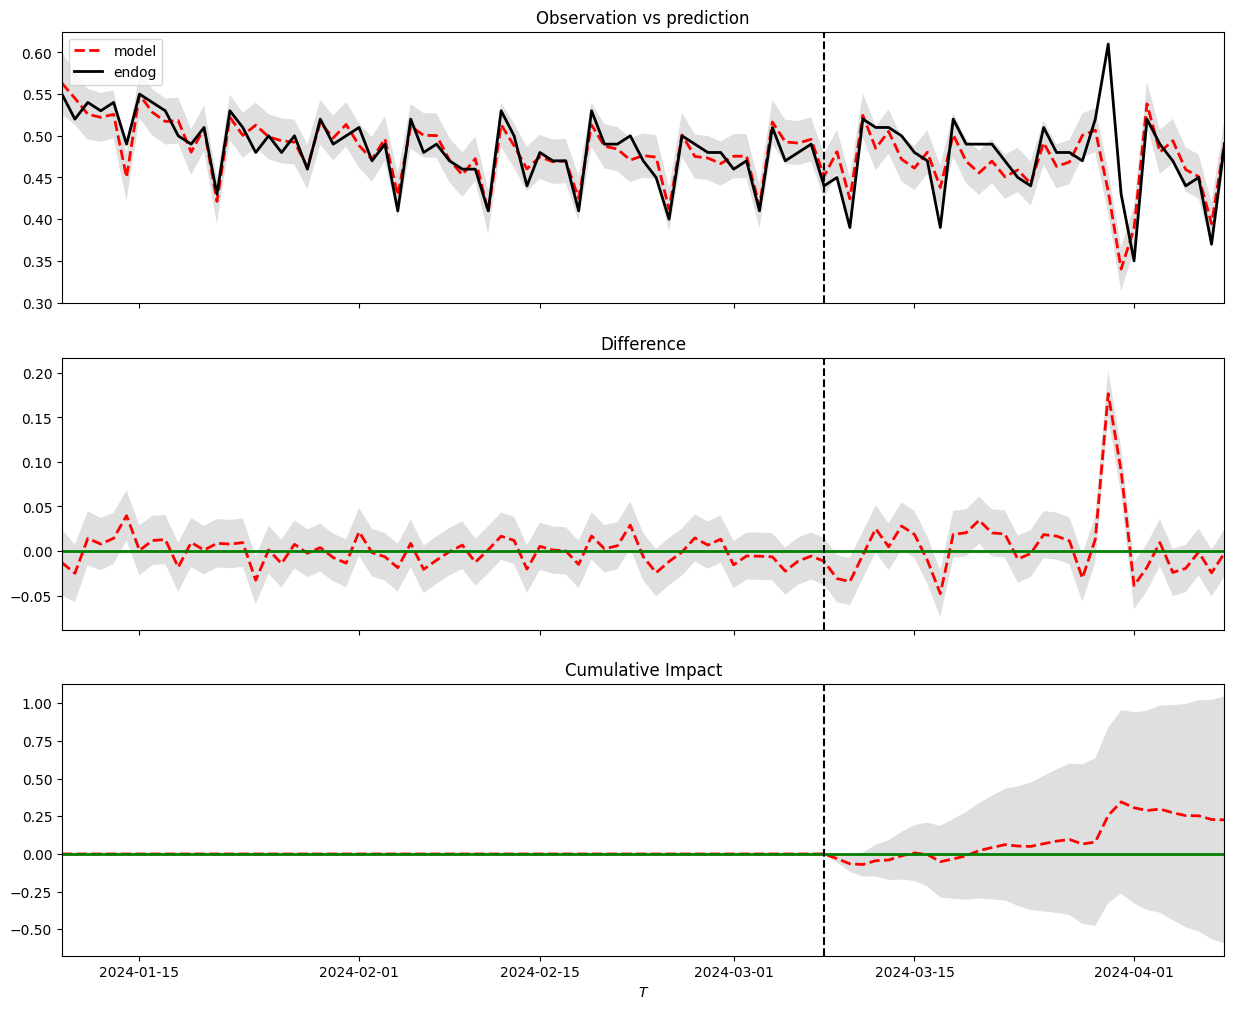

In [105]:
START_DATE = "2024-01-08"
END_DATE = p['p_creation_date'].max().strftime('%Y-%m-%d') # Last date in the dataset
TREATMENT_DATE = "2024-03-08"
POST_TREATMENT_DATE = "2024-03-09"

pre_period = [pd.to_datetime(date) for date in [START_DATE, TREATMENT_DATE]]
post_period = [pd.to_datetime(date) for date in [POST_TREATMENT_DATE, END_DATE]]

ts_impact = CausalImpact(scm_data, pre_period, post_period)
ts_impact.run()

ts_impact.plot()